# Введение

Заказчик - маркетинговое агентство. Заказчик предоставил данные за год о покупках в трех не связанных между собой магазинах: 
 - магазин одежды
 - небольшой магазин подарков
 - маркетплейс

Данные обезличены. Также у нас нет информации об ассортименте магазинов. Но есть дата покупки, цена и количество товара.

**Цель:** предсказать факт покупки каждого клиента в ближайшие 30 дней.

**Предварительный план работы:**

1. Ознакомиться с данными.
2. Проанализировать данные, найти полезные для создания признаков закономерности.
3. Создать целевой признак, синтезировать обучающие признаки.
4. Разделить данные на выборки, обосновать выбор метрики качества решения, провести обучение моделей.
5. Выбрать лучшую модель, оценить ее.
6. Подвести итоги исследования.

# Загрузка данных

In [1]:
# импортируем библиотеки
from pathlib import Path
from datetime import timedelta
import warnings

# отфильтруем предупреждение об ожидаемых изменениях в pandas 3.0
warnings.filterwarnings("ignore", "\nPyarrow", DeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from phik.report import plot_correlation_matrix
from catboost import (
    CatBoostClassifier, 
    Pool
)
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    f1_score,
    recall_score,
    precision_score
)
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# сохраним путь к файлам
PATH = Path("E:/purchases_submission/")

# зафиксируем параметр random state
RS = 45

In [2]:
# загрузим данные магазина одежды
apparel = pd.read_csv(
    PATH/'apparel-purchases.csv',
    parse_dates = ['date'] # спарсим даты заказов
)

# проверим результат
apparel.head(3)

,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
1,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
2,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message


In [3]:
# загрузим данные магазина подарков
gifts = pd.read_csv(
    PATH/'gifts-purchases.csv',
    parse_dates = ['date'] # спарсим даты заказов
)

# проверим результат
gifts.head(3)

,client_id,quantity,price,date,message_id,recommended_by
0,1515915625803894158,1,8943.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
1,1515915625803894158,1,46369.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
2,1515915625803894158,1,4666.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message


In [4]:
# загрузим данные маркетплейса
marketplace = pd.read_csv(
    PATH/'marketplace-purchases.csv',
    parse_dates = ['date'] # спарсим даты заказов
)

# проверим результат
marketplace.head(3)

,client_id,quantity,price,message_id,created_at,date
0,1515915625440944408,1,6298.0,1515915625440944408-1752-6450b79616277,2023-05-02,2023-05-02 08:49:57
1,1515915625440992498,1,7318.0,1515915625440992498-1818-646b35d089c98,2023-05-22,2023-05-22 13:52:13
2,1515915625441026424,1,65798.0,1515915625441026424-1802-64634e24a2cb9,2023-05-17,2023-05-17 11:21:04


In [5]:
# напишем функцию проверки датасета
def check_data(df):
    display(
        df.info(),
        df.nunique(),
        df.describe(include='all', datetime_is_numeric=True),
        df.sample(5, random_state=RS)
    )
    print('Полных дубликатов строк:', df.duplicated().sum())
    print('Пропусков:')
    display(df.isna().sum())

    # проверим монотонность временного ряда
    print('Временная последовательность соблюдена:', df['date'].is_monotonic_increasing)

    # проверим временной ряд на повторы
    print('Повторов timestamp нет:', df['date'].is_unique)

In [6]:
# проверим данные магазина одежды
check_data(apparel)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133104 entries, 0 to 133103
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   client_id       133104 non-null  int64         
 1   quantity        133104 non-null  int64         
 2   price           133104 non-null  float64       
 3   date            133104 non-null  datetime64[ns]
 4   message_id      133104 non-null  object        
 5   recommended_by  133104 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 6.1+ MB


None

client_id         28891
quantity             12
price              3335
date                366
message_id        25426
recommended_by        1
dtype: int64

,client_id,quantity,price,date,message_id,recommended_by
count,1.331040e+05,133104.000000,133104.000000,133104,133104,133104
unique,NaN,NaN,NaN,NaN,25426,1
top,NaN,NaN,NaN,NaN,1515915625489095763-6251-6311b13a4cf78,bulk_message
freq,NaN,NaN,NaN,NaN,271,133104
mean,1.515916e+18,1.004312,1110.433067,2023-04-04 04:27:23.562928128,NaN,NaN
min,1.515916e+18,1.000000,1.000000,2022-10-26 00:00:00,NaN,NaN
25%,1.515916e+18,1.000000,280.000000,2022-12-22 00:00:00,NaN,NaN
50%,1.515916e+18,1.000000,799.000000,2023-04-19 00:00:00,NaN,NaN
75%,1.515916e+18,1.000000,1499.000000,2023-06-16 00:00:00,NaN,NaN
max,1.515916e+18,30.000000,63499.000000,2023-10-26 00:00:00,NaN,NaN


,client_id,quantity,price,date,message_id,recommended_by
111934,1515915625658980016,1,280.0,2022-12-28,1515915625658980016-9111-63ac569dc6e0d,bulk_message
36733,1515915625489295977,1,1390.0,2023-06-23,1515915625489295977-13392-649554cd52578,bulk_message
85806,1515915625863557954,1,399.0,2022-11-26,1515915625863557954-8169-6381ebca6e56b,bulk_message
3601,1515915625468267004,1,2499.0,2023-04-14,1515915625468267004-11855-6439333698784,bulk_message
100199,1515915625975676420,1,99.0,2023-08-05,1515915625975676420-13578-64c90903d27d2,bulk_message


Полных дубликатов строк: 59250
Пропусков:


client_id         0
quantity          0
price             0
date              0
message_id        0
recommended_by    0
dtype: int64

Временная последовательность соблюдена: False
Повторов timestamp нет: False


Столбцы message_id и recommended_by не содержат полезной информации - удалим их.

In [7]:
# удалим бесполезные столбцы и отсортируем по дате
apparel = apparel.drop(['message_id', 'recommended_by'], axis=1).sort_values(by='date')

# проверим результат
display(
    apparel['date'].is_monotonic_increasing,
    apparel.head(3)
)

True

,client_id,quantity,price,date
42189,1515915625558655965,1,1150.0,2022-10-26
16873,1515915625489888679,1,7.0,2022-10-26
16872,1515915625489888679,1,7.0,2022-10-26


In [8]:
# проверим данные магазина подарков
check_data(gifts)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   client_id       811 non-null    int64         
 1   quantity        811 non-null    int64         
 2   price           811 non-null    float64       
 3   date            811 non-null    datetime64[ns]
 4   message_id      811 non-null    object        
 5   recommended_by  811 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 38.1+ KB


None

client_id         326
quantity            2
price             598
date              190
message_id        342
recommended_by      1
dtype: int64

,client_id,quantity,price,date,message_id,recommended_by
count,8.110000e+02,811.000000,811.000000,811,811,811
unique,NaN,NaN,NaN,NaN,342,1
top,NaN,NaN,NaN,NaN,1515915625935652010-16166-6525589bca68f,bulk_message
freq,NaN,NaN,NaN,NaN,22,811
mean,1.515916e+18,1.003699,14468.795314,2023-04-27 23:45:47.718865664,NaN,NaN
min,1.515916e+18,1.000000,656.000000,2022-10-26 00:00:00,NaN,NaN
25%,1.515916e+18,1.000000,3878.000000,2023-01-31 00:00:00,NaN,NaN
50%,1.515916e+18,1.000000,7533.000000,2023-05-22 00:00:00,NaN,NaN
75%,1.515916e+18,1.000000,17938.000000,2023-07-12 00:00:00,NaN,NaN
max,1.515916e+18,2.000000,173586.000000,2023-10-24 00:00:00,NaN,NaN


,client_id,quantity,price,date,message_id,recommended_by
455,1515915625888075683,1,669.0,2023-01-20,1515915625888075683-9483-63c94f34ddd51,bulk_message
246,1515915625835001544,1,12990.0,2023-03-24,1515915625835001544-11036-64157d9de69a5,bulk_message
372,1515915625969512083,1,1946.0,2023-05-22,1515915625951752182-12742-646b14f266095,bulk_message
234,1515915625817415471,1,15112.0,2023-03-15,1515915625817415471-10893-640f2b5dcc047,bulk_message
66,1515915625803892965,1,22316.0,2023-07-18,1515915625864123161-14147-64b5459cbe15b,bulk_message


Полных дубликатов строк: 56
Пропусков:


client_id         0
quantity          0
price             0
date              0
message_id        0
recommended_by    0
dtype: int64

Временная последовательность соблюдена: False
Повторов timestamp нет: False


In [9]:
# удалим бесполезные столбцы и отсортируем по дате
gifts = gifts.drop(['message_id', 'recommended_by'], axis=1).sort_values(by='date')

# проверим результат
display(
    gifts['date'].is_monotonic_increasing,
    gifts.head(3)
)

True

,client_id,quantity,price,date
209,1515915625857065470,1,59990.0,2022-10-26
210,1515915625857065470,1,54040.0,2022-10-26
211,1515915625857065470,1,36720.0,2022-10-26


In [10]:
# проверим данные маркетплейса
check_data(marketplace)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   48182 non-null  int64         
 1   quantity    48182 non-null  int64         
 2   price       48182 non-null  float64       
 3   message_id  48182 non-null  object        
 4   created_at  48182 non-null  object        
 5   date        48182 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 2.2+ MB


None

client_id     17787
quantity         15
price          4991
message_id    20940
created_at      365
date          31340
dtype: int64

,client_id,quantity,price,message_id,created_at,date
count,4.818200e+04,48182.000000,4.818200e+04,48182,48182,48182
unique,NaN,NaN,NaN,20940,365,NaN
top,NaN,NaN,NaN,1515915625557752721-1909-64942a0b0e7f5,2022-11-11,NaN
freq,NaN,NaN,NaN,180,848,NaN
mean,1.515916e+18,1.017413,2.791895e+04,NaN,NaN,2023-04-29 21:02:39.993960448
min,1.515916e+18,1.000000,0.000000e+00,NaN,NaN,2022-10-26 08:35:46
25%,1.515916e+18,1.000000,1.204250e+03,NaN,NaN,2023-02-03 19:49:36
50%,1.515916e+18,1.000000,9.998000e+03,NaN,NaN,2023-04-18 05:33:04.500000
75%,1.515916e+18,1.000000,3.599800e+04,NaN,NaN,2023-08-12 05:08:25.500000
max,1.515916e+18,50.000000,1.299998e+06,NaN,NaN,2023-10-26 13:34:11


,client_id,quantity,price,message_id,created_at,date
10741,1515915625531418205,1,57998.0,1515915625531418205-1762-6453743118489,2023-05-04,2023-05-04 15:55:38
20061,1515915625553273421,1,5798.0,1515915625553273421-2094-6500222b41af3,2023-09-12,2023-09-12 17:33:07
47251,1515915625570041861,1,61998.0,1515915625525686313-1569-63f85a733fa5a,2023-02-24,2023-02-24 11:50:41
26501,1515915625516209860,1,79998.0,1515915625516209860-2046-64e31c1abcfa0,2023-08-22,2023-08-22 04:06:38
37216,1515915625586604069,1,17998.0,1515915625546393273-2047-64e3291cd3f02,2023-08-21,2023-08-21 11:24:50


Полных дубликатов строк: 2159
Пропусков:


client_id     0
quantity      0
price         0
message_id    0
created_at    0
date          0
dtype: int64

Временная последовательность соблюдена: False
Повторов timestamp нет: False


In [11]:
# проверим, что столбцы date и created_at содержат одну и ту же дату
marketplace[pd.to_datetime(marketplace['created_at']).dt.day != marketplace['date'].dt.day].head()

,client_id,quantity,price,message_id,created_at,date


Столбцы содержат одинаковые даты.

In [12]:
# удалим бесполезные столбцы и отсортируем по дате
marketplace = marketplace.drop(['message_id', 'date'], axis=1).sort_values(by='created_at')
marketplace.rename(columns={'created_at': 'date'}, inplace=True)
marketplace['date'] = pd.to_datetime(marketplace['date'])

# проверим результат
display(
    marketplace['date'].is_monotonic_increasing,
    marketplace.head(3)
)

True

,client_id,quantity,price,date
26693,1515915625562386426,1,10598.0,2022-10-26
15660,1515915625519806198,1,2.0,2022-10-27
15662,1515915625519806198,1,77996.0,2022-10-27


**Итоги загрузки:**

1. Мы загрузили данные трех несвязанных между собой магазинов.
2. Данные для магазина одежды и маркетплейса представлены за год: с 26.10.2022 по 26.10.2023. Данные магазина подарков содержат строки с 26.10.2022 по 24.10.2023.
3. Мы обнаружили значительное количество полных дубликатов строк.
4. Удалили бесполезные столбцы.

# Анализ данных

## Дубликаты

In [13]:
# посмотрим на дубликаты строк
display(
    apparel[apparel.duplicated()].head(),
    gifts[gifts.duplicated()].head(),
    marketplace[marketplace.duplicated()].head()
)

,client_id,quantity,price,date
16872,1515915625489888679,1,7.0,2022-10-26
560,1515915625468222486,1,3999.0,2022-10-26
82378,1515915625859359111,1,499.0,2022-10-27
82377,1515915625859359111,1,499.0,2022-10-27
2492,1515915625487057033,1,343.0,2022-10-27


,client_id,quantity,price,date
736,1515915625835005143,1,17100.0,2022-11-02
738,1515915625835005143,1,18000.0,2022-11-02
729,1515915625835005077,1,3627.0,2022-11-03
728,1515915625835005077,1,3627.0,2022-11-03
731,1515915625835005077,1,3627.0,2022-11-03


,client_id,quantity,price,date
15668,1515915625519806198,1,84998.0,2022-10-27
19733,1515915625542470986,1,2.0,2022-10-28
19728,1515915625534205649,1,379998.0,2022-10-31
4732,1515915625466048507,1,2.0,2022-10-31
23020,1515915625552920208,1,6998.0,2022-10-31


У нас нет информации о типах товаров в магазинах, поэтому можем предположить, что полные дубликаты строк - это похожие товары в одном заказе, имеющие небольшие различия. Например, одежда разных размеров или предметы разных цветов. Оставим дубликаты как есть.

## Распределение покупок во времени

Проверим количество покупок по датам на протяжении всего срока наблюдений:

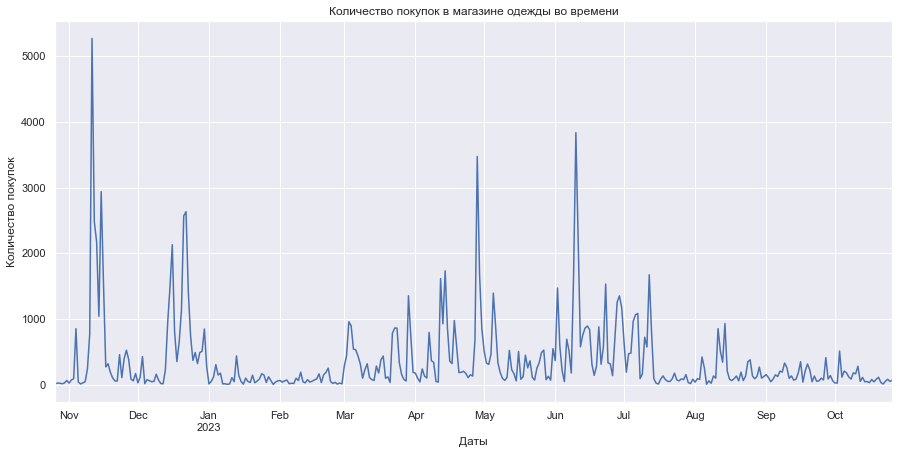

In [14]:
# используем стиль графиков seaborn
sns.set_theme()

# сгруппируем покупки по датам
def purchase_dates_plot(df, df_name):
    purchase_dates = df.groupby('date')['client_id'].count()
    purchase_dates.plot(figsize=(15, 7))
    plt.title(f'Количество покупок в {df_name} во времени')
    plt.ylabel('Количество покупок')
    plt.xlabel('Даты')
    plt.show()

# получим распределение покупок во времени в магазине одежды
purchase_dates_plot(apparel, 'магазине одежды')

В магазине одежды видны всплески в середине ноября, перед новым годом, перед началом мая и в середине июня. Всплески можно объяснить черной пятницей, покупкой одежды к празднованию нового года и в качестве подарка, а также перед периодами массовых отпусков.

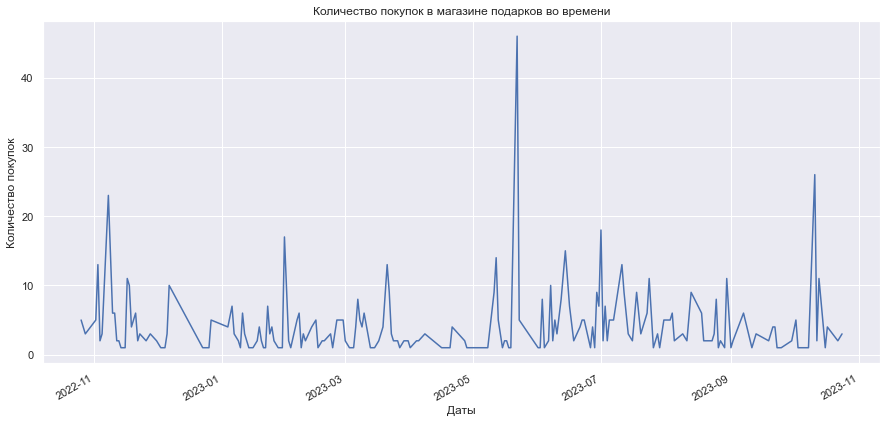

In [15]:
# получим распределение покупок во времени в магазине подарков
purchase_dates_plot(gifts, 'магазине подарков')

В случае с магазином подарков не удалось выяснить логику всплесков покупательской активности, поскольку мы ничего не знаем о товарах.

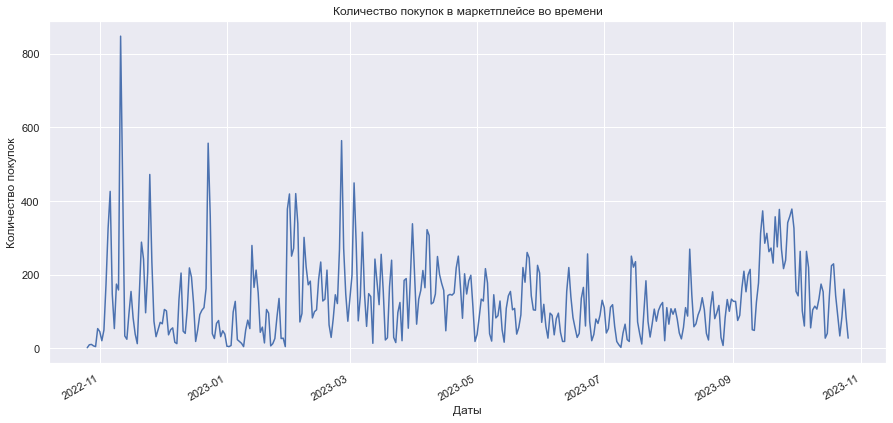

In [16]:
# получим распределение покупок во времени в маркетплейсе
purchase_dates_plot(marketplace, 'маркетплейсе')

Продажи маркетплейса распределилилсь довольно равномерно в течении года, с периодическими всплесками. Наибольшая просадка продаж заметна в январе - видимо она связана с новогодними праздниками и общим спадом активности.

Мы, к сожалению, не сможем использовать информацию о сезонных всплесках покупок, поскольку данные представлены лишь за один год, а предсказать нам нужно только последние 30 дней. Далее извлечем статистическую информацию о покупках клиентов:

In [17]:
def get_stats(data):
    df = data.copy()
    # найдем сумму каждой покупки
    df['total'] = df['quantity'] * df['price']

    # объединим заказы клиента за день в один заказ
    df = df.groupby(['client_id', 'date']).agg({'total': ['sum']})  # суммируем покупки за день
    df.columns = ['total']
    df.reset_index(inplace=True)
    
    # посчитаем количество и сумму покупок каждого клиента
    client_purchases = df.groupby(['client_id']).agg({
        'date': ['count'],  
        'total': ['sum']   
    })
    client_purchases.columns = ['num_purchases', 'user_total']
    client_purchases.reset_index(inplace=True)

    # найдем интервал с каждого предыдущего заказа клиента
    df['days_interval'] = df.groupby(['client_id'])['date'].diff().dt.days

     # найдем минимальное и максимальное количество дней между заказами
    user_order_stats = df.groupby(['client_id'])['days_interval'].agg(['max'])
    user_order_stats.columns = ['max_interval']

    # найдем давность последней сделки клиента
    # найдем последнюю дату покупки
    last_order = df.groupby(['client_id'])['date'].agg(['max'])
    last_order.columns = ['date']
    # добавим столбец для фильтрации предыдущей даты покупки
    last_order['last_order'] = 1
    prev_order = df.merge(last_order, on=['client_id', 'date'], how='left')
    prev_order.fillna(0, inplace=True)
    # найдем предыдущую дату покупки
    prev_order = prev_order[prev_order['last_order'] != 1].groupby(['client_id'])['date'].agg(['max'])
    # вычтем из последней даты предыдущую, получим давность последней сделки клиента
    last_order['recency'] = np.subtract(last_order['date'], prev_order['max']).dt.days
    recency = last_order['recency'].to_frame()

    # добавим количество и сумму покупок каждого клиента, статы интервалов заказов клиента
    df = client_purchases.merge(user_order_stats, on=['client_id'], how='left')
    # добавим давность последней сделки клиента
    df = df.merge(recency, on=['client_id'], how='left')          
    
    # заполним нулями значения для единичных заказов
    df = df.fillna(0)

    # сохраним в индекс id клиентов чтобы не включать их в графики
    df = df.set_index('client_id')

    # конвертируем числа с плавающей точкой в целые
    df = df.astype(int)

    return df

In [18]:
# найдем статы клиентов для каждого магазина
apparel_stats = get_stats(apparel)
gifts_stats = get_stats(gifts)
marketplace_stats = get_stats(marketplace)

# проверим результат
display(
    apparel_stats.head(3),
    gifts_stats.head(3),
    marketplace_stats.head(3)
)

,num_purchases,user_total,max_interval,recency
client_id,,,,
1515915625468061003,1,16235,0,0
1515915625468061170,3,33601,80,80
1515915625468061994,2,1012,29,29


,num_purchases,user_total,max_interval,recency
client_id,,,,
1515915625803180506,1,33961,0,0
1515915625803180756,1,5990,0,0
1515915625803180771,1,4824,0,0


,num_purchases,user_total,max_interval,recency
client_id,,,,
1515915625440099873,2,33216,24,24
1515915625440939402,1,75998,0,0
1515915625440944408,3,81178,62,50


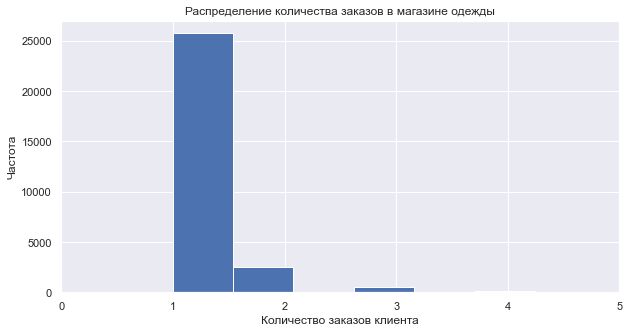

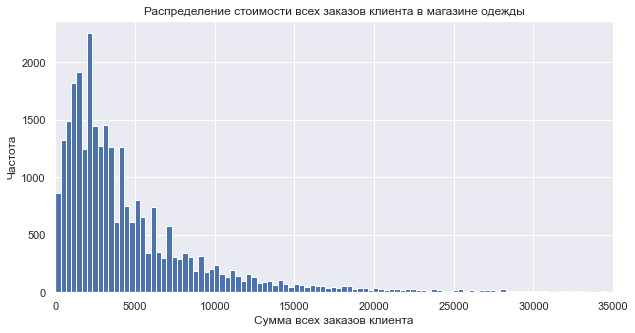

In [19]:
# проверим распределение количества и суммы заказов в магазине одежды
apparel_stats['num_purchases'].hist(bins=50, figsize=(10, 5));
plt.title('Распределение количества заказов в магазине одежды')
plt.ylabel('Частота')
plt.xlabel('Количество заказов клиента')
plt.xlim(0, 5)
plt.show()

apparel_stats['user_total'].hist(bins=700, figsize=(10, 5));
plt.title('Распределение стоимости всех заказов клиента в магазине одежды')
plt.ylabel('Частота')
plt.xlabel('Сумма всех заказов клиента')
plt.xlim(0, 35000)
plt.show()

Большая часть клиентов магазина одежды сделала один заказ. Подавляющее большинство клиентов суммарно потратило не более 5000 р.

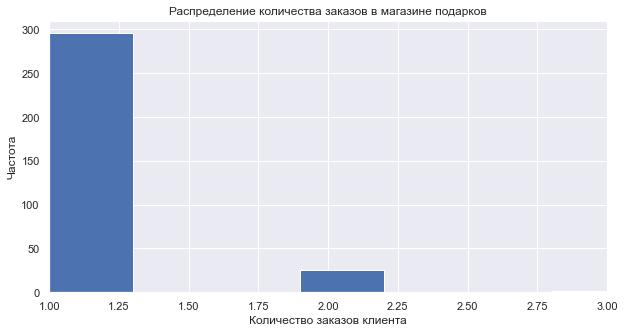

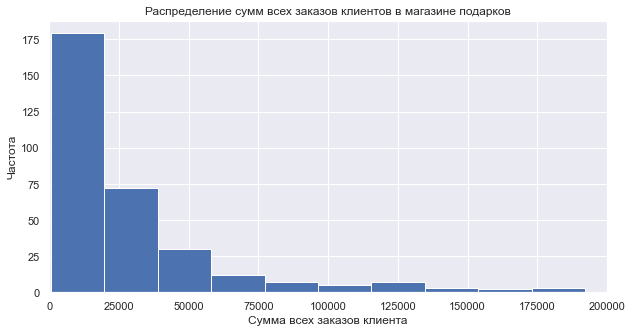

In [20]:
# проверим распределение количества и суммы заказов в магазине подарков
gifts_stats['num_purchases'].hist(bins=10, figsize=(10, 5));
plt.title('Распределение количества заказов в магазине подарков')
plt.ylabel('Частота')
plt.xlabel('Количество заказов клиента')
plt.xlim(1, 3)
plt.show()

gifts_stats['user_total'].hist(bins=50, figsize=(10, 5));
plt.title('Распределение сумм всех заказов клиентов в магазине подарков')
plt.ylabel('Частота')
plt.xlabel('Сумма всех заказов клиента')
plt.xlim(0, 200000)
plt.show()

Большая часть клиентов магазина подарков тоже сделала один заказ. Подавляющее большинство клиентов суммарно потратило не более 35000 р.

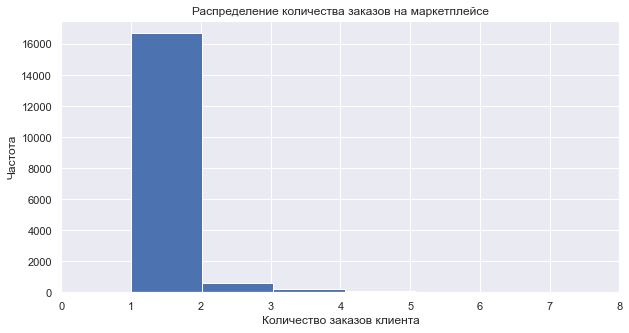

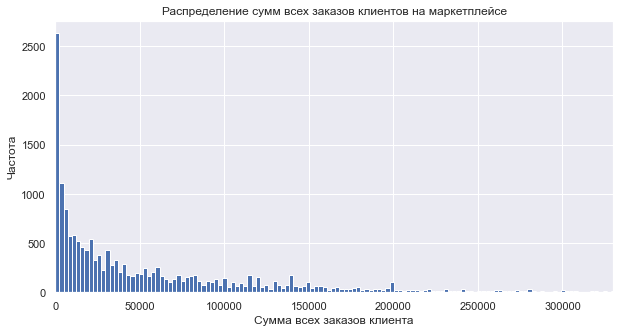

In [21]:
# проверим распределение количества и суммы заказов в маркетплейсе
marketplace_stats['num_purchases'].hist(bins=50, figsize=(10, 5));
plt.title('Распределение количества заказов на маркетплейсе')
plt.ylabel('Частота')
plt.xlabel('Количество заказов клиента')
plt.xlim(0, 8)
plt.show()

marketplace_stats['user_total'].hist(bins=7000, figsize=(10, 5));
plt.title('Распределение сумм всех заказов клиентов на маркетплейсе')
plt.ylabel('Частота')
plt.xlabel('Сумма всех заказов клиента')
plt.xlim(0, 330000)
plt.show()

Большая часть клиентов маркетплейса тоже сделала один заказ. Подавляющее большинство клиентов суммарно потратило не более 50 000 р. При этом значительное количество клиентов потратило небольшую сумму. Рассмотрим эти данные ближе:

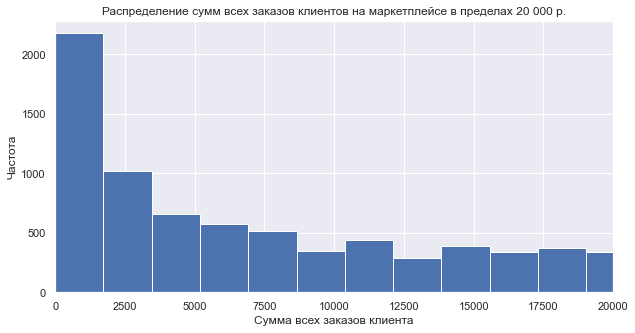

In [22]:
marketplace_stats['user_total'].hist(bins=10000, figsize=(10, 5));
plt.title('Распределение сумм всех заказов клиентов на маркетплейсе в пределах 20 000 р.')
plt.ylabel('Частота')
plt.xlabel('Сумма всех заказов клиента')
plt.xlim(0, 20000)
plt.show()

Довольно много клиентов маркетплейса потратили не более 5000 рублей

Во всех трех магазинах подавляющее большинство клиентов совершило по одному заказу. Общие суммы покупок каждого клиента различны во всех магазинах. В магазине одежды клиенты суммарно тратят меньше всего. В магазине подарков и на маркетиплейсе тратят существенно больше.

При обработке данных попробуем создать на кластеры клиентов по общей сумме и найти признак по таргету для каждого кластера - это будет доля клиентов, совершивших покупку в целевом периоде. Предположим, что клиенты с более высокой общей суммой чаще оформляют заказы и попадают в целевой период.

**Итоги анализа данных:**

- Продажи во всех магазинах имеют нормальный характер, с вплесками и падениями в определенные периоды.
- Чаще всего клиенты совершают один заказ в магазине.
- При обработке данных проверим гипотезу об увеличении доли целевого признака в кластерах клиентов с высокими общими суммами покупок.

# Обработка данных

## Синтез признаков

Создадим целевой признак на основе последних 30 дней датасета. Если клиент совершил покупку в этот период, присваиваем ему положительный класс.

In [23]:
def get_target(data, target_period):
    df = data.copy()
    # найдем порог целевого периода датасета
    threshold = df['date'].max() - timedelta(days=target_period)
    # найдем клиентов, совершивших покупку в целевой период
    target_clients = df[df['date'] > threshold]['client_id'].drop_duplicates().to_frame()
    # добавим столбец целевого признака
    target_clients['target'] = 1

    # уберем целевой период из датасета
    df = df[df['date'] <= threshold]

    # добавим целевой признак всем клиентам
    df = df.merge(target_clients, on=['client_id'], how='left')
    df.fillna(0, inplace=True)
    df['target'] = df['target'].astype(int)
    
    return df

Данные для магазина подарков представляены только до 24 октября 2023, что на два дня меньше чем у маркетплейса и магазина одежды. Но мы обрабатываем отдельно данные каждого магазина, поэтому будет корректно отсечь 30 дней и для магазина подарков тоже:

In [24]:
# получим целевой признак
apparel_targeted = get_target(apparel, 30)
gifts_targeted = get_target(gifts, 30)
marketplace_targeted = get_target(marketplace, 30)

# проверим результат
display(
    apparel_targeted.head(3),
    apparel_targeted.shape[0],
    gifts_targeted.head(3),
    gifts_targeted.shape[0],
    marketplace_targeted.head(3),
    marketplace_targeted.shape[0]
)

,client_id,quantity,price,date,target
0,1515915625558655965,1,1150.0,2022-10-26,0
1,1515915625489888679,1,7.0,2022-10-26,0
2,1515915625489888679,1,7.0,2022-10-26,0


129695

,client_id,quantity,price,date,target
0,1515915625857065470,1,59990.0,2022-10-26,0
1,1515915625857065470,1,54040.0,2022-10-26,0
2,1515915625857065470,1,36720.0,2022-10-26,0


751

,client_id,quantity,price,date,target
0,1515915625562386426,1,10598.0,2022-10-26,0
1,1515915625519806198,1,2.0,2022-10-27,0
2,1515915625519806198,1,77996.0,2022-10-27,0


43456

Добавим прочие признаки к датасету:

In [25]:
def get_features(df_targeted):
    # получим и добавим признаки
    df = get_stats(df_targeted)
    df = df_targeted[['client_id', 'target']].drop_duplicates().merge(df, on=['client_id'], how='left')
    return df

In [26]:
# добавим признаки по каждому магазину
apparel_featured = get_features(apparel_targeted)
gifts_featured = get_features(gifts_targeted)
marketplace_featured = get_features(marketplace_targeted)

# проверим результат
display(
    apparel_featured.head(3),
    apparel_featured.shape[0],
    gifts_featured.head(3),
    gifts_featured.shape[0],
    marketplace_featured.head(3),
    marketplace_featured.shape[0]
)

,client_id,target,num_purchases,user_total,max_interval,recency
0,1515915625558655965,0,1,3298,0,0
1,1515915625489888679,0,1,2213,0,0
2,1515915625587818098,0,1,17998,0,0


28236

,client_id,target,num_purchases,user_total,max_interval,recency
0,1515915625857065470,0,1,174768,0,0
1,1515915625842031428,0,1,4821,0,0
2,1515915625835005143,0,1,70200,0,0


308

,client_id,target,num_purchases,user_total,max_interval,recency
0,1515915625562386426,0,1,10598,0,0
1,1515915625519806198,0,1,461985,0,0
2,1515915625561420490,0,1,11,0,0


16149

## Корреляционный анализ признаков

Визуализируем фи-матрицу корреляции признаков:

In [27]:
def get_correlation_plot(df, interval_cols):
    # создадим матрицу фи-коэффициентов
    # передадим методу список численных признаков
    phik_matrix = df.phik_matrix(interval_cols=interval_cols)
    
    # визуализируем матрицу фи-коэффициентов
    plot_correlation_matrix(
        phik_matrix.values,
        x_labels=phik_matrix.columns,
        y_labels=phik_matrix.index,
        vmin=0,
        vmax=1,
        color_map='Greens',
        title=r'$\phi_K$ корреляция признаков',
        fontsize_factor=1.2,
        figsize=(10, 7))
    plt.xticks(rotation=0)
    plt.tight_layout()

['num_purchases', 'user_total', 'max_interval', 'recency']

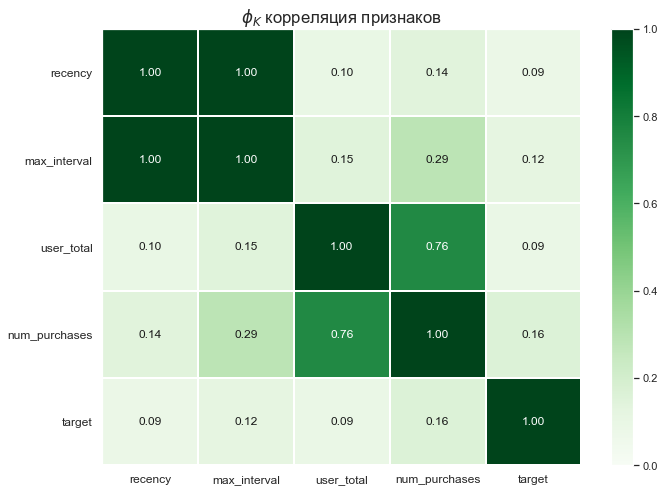

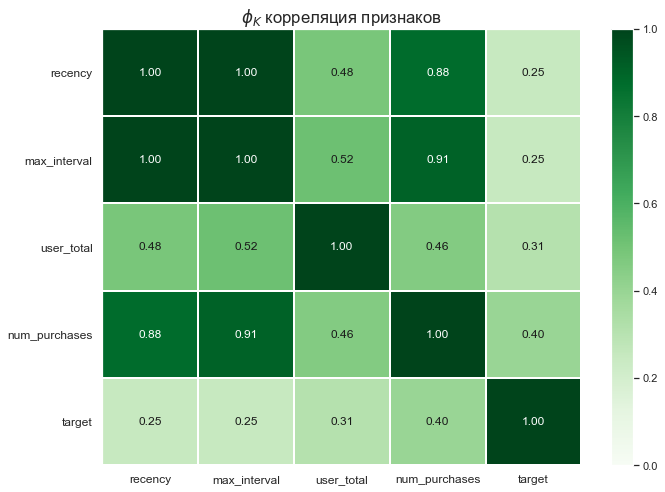

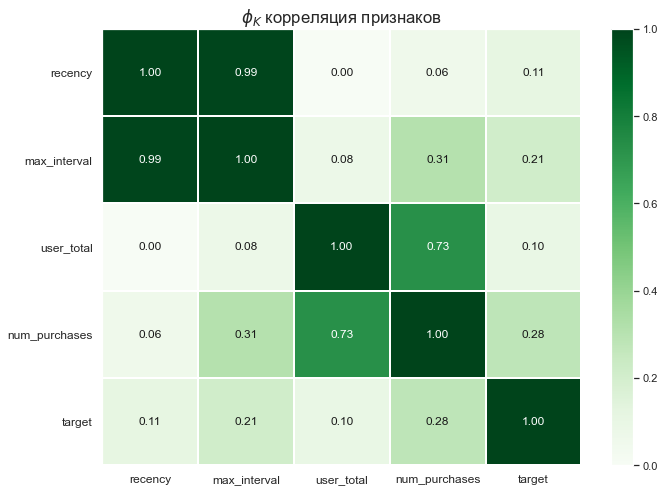

In [28]:
# создадим список численных признаков для матрицы
interval_cols = list(apparel_featured.drop(['client_id', 'target'], axis=1).columns)
# проверим список
display(interval_cols)

# создадим матрицу для каждого магазина
get_correlation_plot(apparel_featured.drop(['client_id'], axis=1), interval_cols)
get_correlation_plot(gifts_featured.drop(['client_id'], axis=1), interval_cols)
get_correlation_plot(marketplace_featured.drop(['client_id'], axis=1), interval_cols)

**Анализ корреляции:**

- Сильнейшую корреляцию показал максимальный интервал между заказами и давность последней сделки клиента. Эти признаки не тождественны, но могут совпадать, особенно если заказов не очень много.
- Общая сумма покупок и количество заказов заметно коррелируют, но это естественно: чем больше заказов клиент совершил, тем выше накопленная общая стоимость заказов.
- Многие признаки в датасете магазина подарков сильно коррелируют. Дело в том, что данных из этого магазина очень мало - лишь несколько сотен строк.
- Сильнее всего с целевым признаком коррелируют максимальный интервал между заказами и количество заказов.

## Разделение на выборки

Сформируем выборки по каждому магазину отдельно. Так мы обеспечим нужную пропорцию разделения для магазина подарков, где данных крайне мало:

In [29]:
# сформируем выборки по магазину одежды
apparel_X_train, apparel_X_test, apparel_y_train, apparel_y_test = train_test_split(
    apparel_featured.drop(['target'], axis=1), 
    apparel_featured['target'],
    train_size=.8, 
    random_state=RS
)

# проверим результат
display(   
    apparel_X_train.shape,
    apparel_X_test.shape,
    apparel_y_train.shape,
    apparel_y_test.shape
)

(22588, 5)

(5648, 5)

(22588,)

(5648,)

Данных магазина подарков очень мало. Чтобы оба класса попали в тестовую выборку, увеличим ее долю.

In [30]:
# сформируем выборки по магазину подарков
gifts_X_train, gifts_X_test, gifts_y_train, gifts_y_test = train_test_split(
    gifts_featured.drop(['target'], axis=1), 
    gifts_featured['target'],
    train_size=.7, 
    random_state=RS
)

# проверим результат
display(   
    gifts_X_train.shape,
    gifts_X_test.shape,
    gifts_y_train.shape,
    gifts_y_test.shape
)

(215, 5)

(93, 5)

(215,)

(93,)

In [31]:
# сформируем выборки по маркетплейсу
marketplace_X_train, marketplace_X_test, marketplace_y_train, marketplace_y_test = train_test_split(
    marketplace_featured.drop(['target'], axis=1), 
    marketplace_featured['target'],
    train_size=.8, 
    random_state=RS
)

# проверим результат
display(   
    marketplace_X_train.shape,
    marketplace_X_test.shape,
    marketplace_y_train.shape,
    marketplace_y_test.shape
)

(12919, 5)

(3230, 5)

(12919,)

(3230,)

In [32]:
# проверим дисбаланс целевого признака для каждого магазина
display(
    apparel_y_train.value_counts(),
    apparel_y_test.value_counts(),
    gifts_y_train.value_counts(),
    gifts_y_test.value_counts(),
    marketplace_y_train.value_counts(),
    marketplace_y_test.value_counts(),
)

0    22459
1      129
Name: target, dtype: int64

0    5619
1      29
Name: target, dtype: int64

0    212
1      3
Name: target, dtype: int64

0    92
1     1
Name: target, dtype: int64

0    12519
1      400
Name: target, dtype: int64

0    3139
1      91
Name: target, dtype: int64

У всех магазинов ярко выраженный дисбаланс классов. Клиентов, совершивших покупку в целевом периоде крайне мало.

## Обработка дисбаланса

Данных у нас мало, поэтому целесообразно использовать upsampling. Синтезируем новые данные при помощи SMOTE.

In [33]:
def get_upsample(X_train, y_train, k_neighbors, random_state):
    # настроим синтезатор
    upsampler = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
    
    # сбалансируем тренировочную выборку
    X_train_up, y_train_up = upsampler.fit_resample(X_train, y_train)

    return X_train_up, y_train_up

In [34]:
# сбалансируем тренировочную выборку
apparel_X_train_up, apparel_y_train_up = get_upsample(apparel_X_train, apparel_y_train, 5, RS)
gifts_X_train_up, gifts_y_train_up = get_upsample(gifts_X_train, gifts_y_train, 2, RS)  # снизим число соседей для магазина подарков, так как данных коайне мало
marketplace_X_train_up, marketplace_y_train_up = get_upsample(marketplace_X_train, marketplace_y_train, 5, RS)

# проверим результат
display(
    apparel_X_train_up.shape,
    apparel_y_train_up.value_counts(),
    gifts_X_train_up.shape,
    gifts_y_train_up.value_counts(),
    marketplace_X_train_up.shape,
    marketplace_y_train_up.value_counts()
)

(44918, 5)

0    22459
1    22459
Name: target, dtype: int64

(424, 5)

0    212
1    212
Name: target, dtype: int64

(25038, 5)

0    12519
1    12519
Name: target, dtype: int64

## Кластеризация клиентов по общей сумме покупок

Проверим нашу гипотезу о высокой доли целевого признака у клиентов с большими общими суммами покупок.

In [35]:
def check_cluster_target(df_featured, cluster_threshold):
    df = df_featured.copy()
    # найдем признак кластера с высокой общей суммой покупок
    df['total_cluster'] = np.where(df['user_total'] > cluster_threshold, 1, 0)
    
    print(
        f'Доля клиентов, входящих в кластер с общей суммой покупок больше {cluster_threshold}: ', 
        round(len(df[df['total_cluster'] == 1]) / len(df), 5)
    )
    print(
        f'Доля клиентов из кластера с общей суммой покупок больше {cluster_threshold}, совершивших целевую покупку: ', 
        round(df[df['total_cluster'] == 1]['target'].mean(), 5)
    )
    print(
        f'Доля клиентов из кластера с общей суммой покупок меньше {cluster_threshold}, совершивших целевую покупку: ', 
        round(df[df['total_cluster'] == 0]['target'].mean(), 5)
    )
    print(
        'Доля всех клиентов, совершивших целевую покупку: ', 
        round(df['target'].mean(), 5)
    )

In [36]:
# проверим гипотезу для магазина одежды
check_cluster_target(apparel_featured, 6000)

Доля клиентов, входящих в кластер с общей суммой покупок больше 6000:  0.24865
Доля клиентов из кластера с общей суммой покупок больше 6000, совершивших целевую покупку:  0.00826
Доля клиентов из кластера с общей суммой покупок меньше 6000, совершивших целевую покупку:  0.00471
Доля всех клиентов, совершивших целевую покупку:  0.0056


Клиенты из кластера с высокой суммой покупок составляют примерно четверть от общего количества клиентов. Они совершают целевую покупку приблизительно в два раза чаще прочих.

In [37]:
# проверим гипотезу для магазина подарков
check_cluster_target(gifts_featured, 35000)

Доля клиентов, входящих в кластер с общей суммой покупок больше 35000:  0.24351
Доля клиентов из кластера с общей суммой покупок больше 35000, совершивших целевую покупку:  0.04
Доля клиентов из кластера с общей суммой покупок меньше 35000, совершивших целевую покупку:  0.00429
Доля всех клиентов, совершивших целевую покупку:  0.01299


Клиенты из кластера с высокой суммой покупок составляют примерно четверть от общего количества клиентов. Они совершают целевую покупку приблизительно в десять раз чаще прочих.

In [38]:
# проверим гипотезу для маркетплейса
check_cluster_target(marketplace_featured, 90000)

Доля клиентов, входящих в кластер с общей суммой покупок больше 90000:  0.25296
Доля клиентов из кластера с общей суммой покупок больше 90000, совершивших целевую покупку:  0.04137
Доля клиентов из кластера с общей суммой покупок меньше 90000, совершивших целевую покупку:  0.02669
Доля всех клиентов, совершивших целевую покупку:  0.0304


Клиенты из кластера с высокой суммой покупок составляют примерно четверть от общего количества клиентов. Они совершают целевую покупку приблизительно в два раза чаще прочих. Наша гипотеза подтвердилась для всех магазинов - используем эти данные для создания признака.

In [39]:
def get_target_feature(X_train, X_test, cluster_threshold, return_train=False):
    train = X_train.copy()
    test = X_test.copy()
    # найдем признак кластера с высокой общей суммой покупок
    train['total_cluster'] = np.where(train['user_total'] > cluster_threshold, 1, 0)
    
    # найдем средний таргет для кластеров
    mean_target_1_cluster = len(train[train['total_cluster'] == 1]) / len(train)
    mean_target_0_cluster = len(train[train['total_cluster'] == 0]) / len(train)
    train['mean_cluster_target'] = np.where(train['total_cluster'] == 1, mean_target_1_cluster, mean_target_0_cluster)

    # добавим средний таргет для тестовой выборки
    test['total_cluster'] = np.where(test['user_total'] > cluster_threshold, 1, 0)
    test['mean_cluster_target'] = np.where(test['total_cluster'] == 1, mean_target_1_cluster, mean_target_0_cluster)

    # уберем ненужный столбец
    train.drop(['total_cluster'], axis=1, inplace=True)
    test.drop(['total_cluster'], axis=1, inplace=True)

    # вернем нужные выборки в зависимости от условий
    if return_train:
        return train, test
    return test

Создадим признак кластера по таргету на основе выборки до балансировки. Так мы избежим создания признака на искусственных данных. Добавим значение признака к тестовой выборке и к сбалансированной тренировочной выборке:

In [40]:
# создадим признак таргета кластера для тренировочной сбалансированной выборки
apparel_clustered_X_train = get_target_feature(apparel_X_train, apparel_X_train_up, 6000, False)
gifts_clustered_X_train = get_target_feature(gifts_X_train, gifts_X_train_up, 35000, False)
marketplace_clustered_X_train = get_target_feature(marketplace_X_train, marketplace_X_train_up, 90000, False)

# создадим признак таргета кластера для тестовой выборки
apparel_clustered_X_test = get_target_feature(apparel_X_train, apparel_X_test, 6000, False)
gifts_clustered_X_test = get_target_feature(gifts_X_train, gifts_X_test, 35000, False)
marketplace_clustered_X_test = get_target_feature(marketplace_X_train, marketplace_X_test, 90000, False)

# проверим результат
display(
    apparel_clustered_X_train.head(1),
    apparel_clustered_X_train['mean_cluster_target'].value_counts(),
    apparel_clustered_X_test.head(1),
    apparel_clustered_X_test['mean_cluster_target'].value_counts(),
    gifts_clustered_X_train.head(1),
    gifts_clustered_X_train['mean_cluster_target'].value_counts(),
    gifts_clustered_X_test.head(1),
    gifts_clustered_X_test['mean_cluster_target'].value_counts(),
    marketplace_clustered_X_train.head(1),
    marketplace_clustered_X_train['mean_cluster_target'].value_counts(),
    marketplace_clustered_X_test.head(1),
    marketplace_clustered_X_test['mean_cluster_target'].value_counts()
)

,client_id,num_purchases,user_total,max_interval,recency,mean_cluster_target
0,1515915625703361475,1,3998,0,0,0.750177


0.750177    30093
0.249823    14825
Name: mean_cluster_target, dtype: int64

,client_id,num_purchases,user_total,max_interval,recency,mean_cluster_target
3825,1515915625468267083,1,330,0,0,0.750177


0.750177    4270
0.249823    1378
Name: mean_cluster_target, dtype: int64

,client_id,num_purchases,user_total,max_interval,recency,mean_cluster_target
0,1515915625897493329,1,8125,0,0,0.772093


0.772093    257
0.227907    167
Name: mean_cluster_target, dtype: int64

,client_id,num_purchases,user_total,max_interval,recency,mean_cluster_target
235,1515915625951763240,2,9263,39,39,0.772093


0.772093    67
0.227907    26
Name: mean_cluster_target, dtype: int64

,client_id,num_purchases,user_total,max_interval,recency,mean_cluster_target
0,1515915625539052563,1,68,0,0,0.746884


0.746884    17479
0.253116     7559
Name: mean_cluster_target, dtype: int64

,client_id,num_purchases,user_total,max_interval,recency,mean_cluster_target
1504,1515915625498567696,2,4748,21,21,0.746884


0.746884    2415
0.253116     815
Name: mean_cluster_target, dtype: int64

In [41]:
# уберем лишнюю колонку
def clean_data(df):
    df_final = df.drop(['client_id'], axis=1)
    display(df_final.columns)
    return df_final

apparel_final_X_train = clean_data(apparel_clustered_X_train)
apparel_final_X_test = clean_data(apparel_clustered_X_test)
gifts_final_X_train = clean_data(gifts_clustered_X_train)
gifts_final_X_test = clean_data(gifts_clustered_X_test)
marketplace_final_X_train = clean_data(marketplace_clustered_X_train)
marketplace_final_X_test = clean_data(marketplace_clustered_X_test)

Index(['num_purchases', 'user_total', 'max_interval', 'recency',
       'mean_cluster_target'],
      dtype='object')

Index(['num_purchases', 'user_total', 'max_interval', 'recency',
       'mean_cluster_target'],
      dtype='object')

Index(['num_purchases', 'user_total', 'max_interval', 'recency',
       'mean_cluster_target'],
      dtype='object')

Index(['num_purchases', 'user_total', 'max_interval', 'recency',
       'mean_cluster_target'],
      dtype='object')

Index(['num_purchases', 'user_total', 'max_interval', 'recency',
       'mean_cluster_target'],
      dtype='object')

Index(['num_purchases', 'user_total', 'max_interval', 'recency',
       'mean_cluster_target'],
      dtype='object')

Данных у нас немного, особенно у магазина подарков, поэтому будет целесообразно объединить информацию по всем магазинам в один датасет.

In [42]:
# объединим датасеты
def concat_data(df1, df2, df3):
    final_df = pd.concat([df1, df2], ignore_index=True)
    final_df = pd.concat([final_df, df3], ignore_index=True)
    display(
        final_df.shape,
        final_df.head(2)
    )
    return final_df

In [43]:
# объединим данные магазинов
total_X_train = concat_data(
    apparel_final_X_train, 
    gifts_final_X_train, 
    marketplace_final_X_train
)
total_y_train = concat_data(
    apparel_y_train_up, 
    gifts_y_train_up, 
    marketplace_y_train_up
)
total_X_test = concat_data(
    apparel_final_X_test, 
    gifts_final_X_test, 
    marketplace_final_X_test
)
total_y_test = concat_data(
    apparel_y_test, 
    gifts_y_test, 
    marketplace_y_test
)

(70380, 5)

,num_purchases,user_total,max_interval,recency,mean_cluster_target
0,1,3998,0,0,0.750177
1,1,2598,0,0,0.750177


(70380,)

0    0
1    0
Name: target, dtype: int32

(8971, 5)

,num_purchases,user_total,max_interval,recency,mean_cluster_target
0,1,330,0,0,0.750177
1,1,6773,0,0,0.249823


(8971,)

0    0
1    0
Name: target, dtype: int32

**Итоги обработки данных:**

- Мы синтезировали целевой признак на основе последних 30 дней датасета. Присвоили положительный класс клиентам, которые совершили покупку в этот период.
- Синтезировали признаки на основе истории покупок каждого клиента
- Выявили сильную корреляцию некоторых признаков - попробуем исключить их из обучения и сравним результаты.
- У всех магазинов ярко выраженный дисбаланс классов. Клиентов, совершивших покупку в целевом периоде, крайне мало. Мы устранили дисбаланс тренировочной выборки при помощи синтетических данных.
- Мы кластеризовали клиентов по общей сумме покупок и добавили признак на основе среднего таргета для каждого кластера.

# Обучение моделей

## Выбор метрики

Нам важно определить как можно больше покупателей, которые совершат покупку в целевом периоде. Таких покупателей очень мало в датасетах, поэтому важно отслеживать recall, чтобы не пропустить потенциальную продажу. Этот параметр будет важнее precision в нашей ситуации. Тем не менее мы не можем совсем пренебречь precision, поэтому при обучении модели используем F1-меру, но также будем отслеживать recall в приоритетном порядке и дополнительно - precision. После обучения настроим модель на максимизацию recall с приемлемым precision, сдвигая порог предсказания.

## Dummy-модель

In [44]:
# создадим константную модель для оценки адекватности наших моделей
dummy = DummyClassifier(strategy='uniform', random_state=RS).fit(total_X_train, total_y_train)
dummy_preds = dummy.predict(total_X_test)

# получим результат dummy-модели
dummy_f1_test = f1_score(total_y_test, dummy_preds)
dummy_recall_test = recall_score(total_y_test, dummy_preds)
dummy_precision_test = precision_score(total_y_test, dummy_preds)

print('F1 dummy-модели: ', dummy_f1_test)
print('Recall dummy-модели: ', dummy_recall_test)
print('Precision dummy-модели: ', dummy_precision_test)

F1 dummy-модели:  0.030834213305174236
Recall dummy-модели:  0.6033057851239669
Precision dummy-модели:  0.015821413090593844


## Градиентный бустинг

In [45]:
# подготовим выборки для градиентного бустинга
X_train_grad = total_X_train.copy()
X_test_grad = total_X_test.copy()

# создадим тренировочный и тестовый пулы для CatBoost
train_pool = Pool(X_train_grad, total_y_train)
test_pool = Pool(X_test_grad, total_y_test)

In [46]:
# зададим параметры модели
model_catboost = CatBoostClassifier(
    random_state=RS,
    eval_metric='F1',
    verbose=100,
)

# пока проведем обучение без подбора гиперпараметров
param_grid_catboost = {
    'early_stopping_rounds':[10]
}
# соберем все вместе и запустим
model_catboost_result = model_catboost.grid_search(
    param_grid_catboost, 
    train_pool, 
    cv=5, 
    refit=True,
    search_by_train_test_split=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7338624	test: 0.7385142	best: 0.7385142 (0)	total: 165ms	remaining: 2m 44s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.740420675
bestIteration = 2

0:	loss: 0.7404207	best: 0.7404207 (0)	total: 351ms	remaining: 0us
Estimating final quality...
Training on fold [0/5]
0:	learn: 0.7359089	test: 0.7378039	best: 0.7378039 (0)	total: 28.9ms	remaining: 28.8s

bestTest = 0.738418953
bestIteration = 11

Training on fold [1/5]
0:	learn: 0.7366829	test: 0.7347073	best: 0.7347073 (0)	total: 17ms	remaining: 17s

bestTest = 0.7356925856
bestIteration = 2

Training on fold [2/5]
0:	learn: 0.7375997	test: 0.7310311	best: 0.7310311 (0)	total: 27ms	remaining: 27s

bestTest = 0.7328481478
bestIteration = 19

Training on fold [3/5]
0:	learn: 0.7357784	test: 0.7383331	best: 0.7383331 (0)	total: 18.9ms	remaining: 18.9s

bestTest = 0.7387004495
bestIteration = 5

Training on fold [4/5]
0:	learn: 0.7354736	test: 0.7394355	best: 0.7394355 (0)	total: 26.3ms	remaining: 26.3s

b

Наша модель довольно быстро переобучается - это видно по раннему срабатыванию детектора переобучения, когда метрика на тестовой подвыборке перестает расти.

In [47]:
# узнаем метрики обученной модели
def get_score(model, result, test_pool, y_test):
    preds = model.predict(test_pool)
    print(result['params'])  # гиперпараметры обученной модели 
    print('F1: ', f1_score(y_test, preds))
    print('Recall: ', recall_score(y_test, preds))
    print('Precision: ', precision_score(y_test, preds))

get_score(model_catboost, model_catboost_result, test_pool, total_y_test)

{'od_wait': 10}
F1:  0.08205128205128205
Recall:  0.3305785123966942
Precision:  0.0468384074941452


Модель показала невысокие метрики на базовых настройках. Далее попробуем исключить часть признаков из обучения, настроить гиперпараметры и поменять порог предстказания для увеличения recall. Проверим признаки обученной модели на важность:

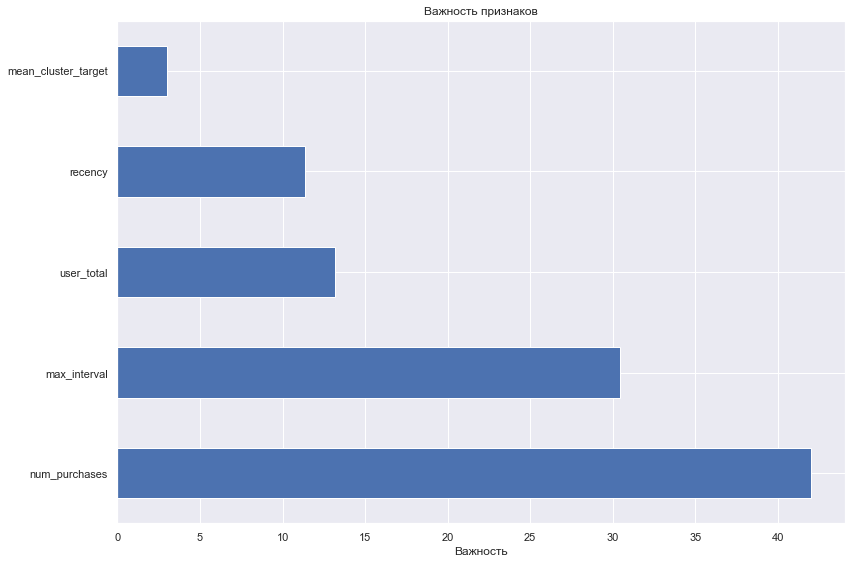

In [48]:
# извлечем из модели важность признаков и отсортируем признаки по доле важности
feature_importances = pd.Series(model_catboost.get_feature_importance(train_pool), X_train_grad.columns).sort_values(ascending=False)

# построим график важности признаков
fig, ax = plt.subplots(figsize=(12, 8))
feature_importances.plot.barh(ax=ax)
ax.set_title("Важность признаков")
ax.set_xlabel('Важность')
fig.tight_layout()

Наименьшую важность показал признак среднего значения таргета для кластера. Далее обучим модель без этого признака. Также в процессе отбора признаков мы исключили минимальный интервал между заказами, оставив максимальный интервал. Оба интервала значительно коррелировали между собой, при этом максимальный интервал сильнее влиял на целевой признак. Отсев признака минимального интервала увеличил показатели метрик.

Наиболее важным признаком оказалось количество заказов клиента, что логично - значительная доля клиентов сделала лишь один заказ за все время наблюдений, следовательно заказа в целевом периоде уже не будет. 

В ходе исследования мы пробовали обучать модель без recency, но это привело к снижению метрик.

In [49]:
# объединим данные всех магазинов без признака среднего таргета по кластеру
total_X_train_no_clusters = concat_data(
    apparel_X_train_up, 
    gifts_X_train_up, 
    marketplace_X_train_up
)
total_X_test_no_clusters = concat_data(
    apparel_X_test, 
    gifts_X_test, 
    marketplace_X_test
)
# уберем лишние столбцы
total_X_train_no_clusters = clean_data(total_X_train_no_clusters)
total_X_test_no_clusters = clean_data(total_X_test_no_clusters)

# подготовим выборки для градиентного бустинга
X_train_grad = total_X_train_no_clusters.copy()
X_test_grad = total_X_test_no_clusters.copy()

# создадим тренировочный и тестовый пулы для CatBoost
train_pool = Pool(X_train_grad, total_y_train)
test_pool = Pool(X_test_grad, total_y_test)

# зададим параметры модели
model_catboost_no_clusters = CatBoostClassifier(
    random_state=RS,
    eval_metric='F1',
    verbose=100,
)

# пока проведем обучение без подбора гиперпараметров
param_grid_catboost = {
    'early_stopping_rounds':[10]
}
# соберем все вместе и запустим
model_catboost_no_clusters_result = model_catboost_no_clusters.grid_search(
    param_grid_catboost, 
    train_pool, 
    cv=5, 
    refit=True,
    search_by_train_test_split=True,
    plot=True
)

(70380, 5)

,client_id,num_purchases,user_total,max_interval,recency
0,1515915625703361475,1,3998,0,0
1,1515915625489049675,1,2598,0,0


(8971, 5)

,client_id,num_purchases,user_total,max_interval,recency
0,1515915625468267083,1,330,0,0
1,1515915625491338392,1,6773,0,0


Index(['num_purchases', 'user_total', 'max_interval', 'recency'], dtype='object')

Index(['num_purchases', 'user_total', 'max_interval', 'recency'], dtype='object')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7351146	test: 0.7397706	best: 0.7397706 (0)	total: 13.2ms	remaining: 13.2s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.7404511768
bestIteration = 2

0:	loss: 0.7404512	best: 0.7404512 (0)	total: 180ms	remaining: 0us
Estimating final quality...
Training on fold [0/5]
0:	learn: 0.7342315	test: 0.7362593	best: 0.7362593 (0)	total: 9.27ms	remaining: 9.26s

bestTest = 0.7384966202
bestIteration = 16

Training on fold [1/5]
0:	learn: 0.7349901	test: 0.7332242	best: 0.7332242 (0)	total: 14.3ms	remaining: 14.2s

bestTest = 0.7345597898
bestIteration = 1

Training on fold [2/5]
0:	learn: 0.7360310	test: 0.7290439	best: 0.7290439 (0)	total: 22.5ms	remaining: 22.5s

bestTest = 0.7304106004
bestIteration = 2

Training on fold [3/5]
0:	learn: 0.7340703	test: 0.7369109	best: 0.7369109 (0)	total: 22.8ms	remaining: 22.7s

bestTest = 0.7388993376
bestIteration = 37

Training on fold [4/5]
0:	learn: 0.7338644	test: 0.7376117	best: 0.7376117 (0)	total: 26.3ms	remaining

In [50]:
get_score(model_catboost_no_clusters, model_catboost_no_clusters_result, test_pool, total_y_test)

{'od_wait': 10}
F1:  0.08641975308641975
Recall:  0.34710743801652894
Precision:  0.04935370152761457


Нам удалось улучшить метрики без признака среднего таргета по кластеру. Далее уменьшим порог срабатывания переобучения, подберем гиперпараметры и оптимальный порог предсказания:

In [51]:
# зададим параметры модели
model_catboost_tuning = CatBoostClassifier(
    early_stopping_rounds=5,
    random_state=RS,
    eval_metric='F1',
    verbose=100,
)

# выберем сетку гиперпараметров модели
param_grid_catboost = {
    'depth':[3, 4, 5, 6],
    'learning_rate': [0.06, 0.03],
    'l2_leaf_reg': [2, 3, 4],
    'boosting_type': ['Ordered', 'Plain']
}
# соберем все вместе и запустим
model_catboost_tuning_result = model_catboost_tuning.grid_search(
    param_grid_catboost, 
    train_pool, 
    cv=5, 
    refit=True,
    search_by_train_test_split=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7333347	test: 0.7373212	best: 0.7373212 (0)	total: 58.6ms	remaining: 58.5s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.7376209448
bestIteration = 1

0:	loss: 0.7376209	best: 0.7376209 (0)	total: 319ms	remaining: 15s
0:	learn: 0.7333347	test: 0.7373212	best: 0.7373212 (0)	total: 53ms	remaining: 53s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.7391163093
bestIteration = 6

1:	loss: 0.7391163	best: 0.7391163 (1)	total: 779ms	remaining: 17.9s
0:	learn: 0.7333347	test: 0.7373212	best: 0.7373212 (0)	total: 46.1ms	remaining: 46.1s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.7375182957
bestIteration = 1

2:	loss: 0.7375183	best: 0.7391163 (1)	total: 1.05s	remaining: 15.8s
0:	learn: 0.7333347	test: 0.7373212	best: 0.7373212 (0)	total: 55.7ms	remaining: 55.7s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.7373211964
bestIteration = 0

3:	loss: 0.7373212	best: 0.7391163 (1)	total: 1.3s	remaining: 1

In [52]:
get_score(model_catboost_tuning, model_catboost_tuning_result, test_pool, total_y_test)

{'depth': 6, 'l2_leaf_reg': 2, 'learning_rate': 0.03, 'boosting_type': 'Plain'}
F1:  0.08235294117647059
Recall:  0.34710743801652894
Precision:  0.04671857619577308


In [53]:
# найдем оптимальный порог вероятности
def get_best_threshold(model_catboost, recall_min, threshold_interval, test_pool, y_test):
    best_score = 0
    # проверим интервал значений порога
    for t in threshold_interval:
        model_catboost.set_probability_threshold(t)
        preds = model_catboost.predict(test_pool)
        score = f1_score(y_test, preds)
        # сохраним лучший порог
        if (score > best_score) & (recall_score(y_test, preds) >= recall_min):
            best_score = score
            best_threshold = t
    # установим оптимальный порог
    model_catboost.set_probability_threshold(best_threshold)
    
    catboost_preds = model_catboost.predict(test_pool)
    print('Лучший F1 на тестовой выборке: ', best_score)
    print('Recall: ', recall_score(y_test, catboost_preds))
    print('Precision: ', precision_score(y_test, catboost_preds))
    print('Оптимальный порог предсказания: ', round(best_threshold, 2))
    
    return best_threshold

Настроим модель для получения recall не ниже 0.7. Так мы сможем определить большую часть клиентов из целевого периода, но не до конца пожертвовать точностью предсказания.

In [54]:
threshold_interval = np.arange(0.2, 0.8, 0.01)
recall_min = 0.7
get_best_threshold(model_catboost_tuning, recall_min, threshold_interval, test_pool, total_y_test)

Лучший F1 на тестовой выборке:  0.03331373701744072
Recall:  0.7024793388429752
Precision:  0.017061421116017664
Оптимальный порог предсказания:  0.28


0.2800000000000001

## Оценка финальной модели

In [55]:
# проверим модель на адекватность
best_model_pred = model_catboost_tuning.predict(test_pool)
pd.DataFrame(
    {
        'dummy': [
            dummy_f1_test, 
            dummy_recall_test, 
            dummy_precision_test
        ],
        'CatBoost': [
            f1_score(total_y_test, best_model_pred), 
            recall_score(total_y_test, best_model_pred), 
            precision_score(total_y_test, best_model_pred)
        ]
    },
    index=['F1', 'Recall', 'Precision']
)

,dummy,CatBoost
F1,0.030834,0.033314
Recall,0.603306,0.702479
Precision,0.015821,0.017061


Настроенная модель показала свою адекватность по сравнению с dummy. Удалось улучшить все метрики. Наша модель небесполезна. Далее построим матрицу ошибок модели:


True Positives(TP) =  3953

True Negatives(TN) =  85

False Positives(FP) =  4897

False Negatives(FN) =  36


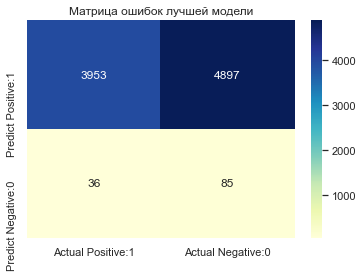

In [56]:
# найдем предсказания и вероятности
best_model_pred_proba = model_catboost_tuning.predict_proba(test_pool)[:, 1]

# найдем матрицу ошибок лучшей модели
cm = confusion_matrix(total_y_test, best_model_pred)

print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

# визуализируем матрицу ошибок лучшей модели
cm_matrix = pd.DataFrame(
    data=cm, 
    columns=['Actual Positive:1', 'Actual Negative:0'], 
    index=['Predict Positive:1', 'Predict Negative:0']
)

sns.heatmap(
    cm_matrix, 
    annot=True, 
    fmt='d', 
    cmap='YlGnBu'
);
plt.title('Матрица ошибок лучшей модели')
plt.show()

Модель правильно определила большинство клиентов, которые совершат покупку в целевом периоде. Но за счет высокой полноты сильно пострадала точность. Модель отнесла к целевому признаку тысячи клиентов, которые не совершали заказ в последние 30 дней. Тем не менее recall в нашей задаче гораздо важнее precision, поскольку целевых клиентов крайне мало, баланс классов очень плохой. Потенциальные покупки принесут прибыль, поэтому так важно определить большую часть таких покупок. Если низкая точность неприемлема, можно сдвинуть порог предсказания, уменьшив полноту. Покажем это на ROC-кривой:

ROC-AUC:  0.6623140495867769


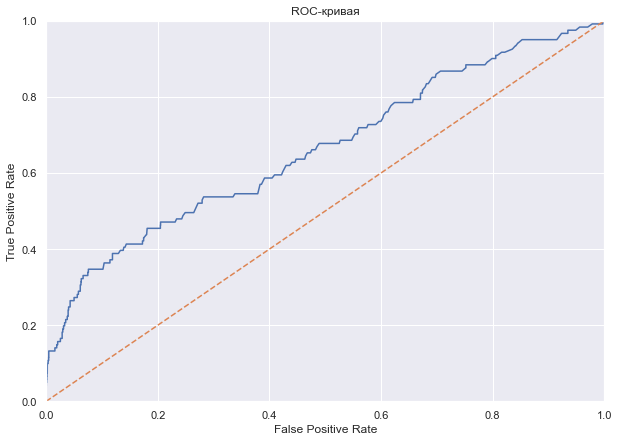

In [57]:
# найдем ROC-AUC
print('ROC-AUC: ', roc_auc_score(total_y_test, best_model_pred_proba))

# построим ROC-кривую
fpr, tpr, thresholds = roc_curve(total_y_test, best_model_pred_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr)

# для сравнения пунктиром отобразим на графике ROC-кривую случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Наша модель показала невысокие метрики, но она не бесполезна, что еще раз подтверждает график. Двигая порог предсказания по ROC-кривой мы сможем балансировать между recall и precision.

**Итог обучения моделей:**

Мы создали не бесполезную модель, которая показала свою адекватность. Сдвинув порог предсказания, нам удалось получить приемлемую полноту, пожертвовав точностью, поскольку это больше отвечает задаче бизнеса. При желании баланс можно изменить, увеличив точность, но снизив полноту.

# Выводы

1. Мы обнаружили значительное количество дубликатов строк, но оставили их. Вероятно дубликаты - это похожие товары в одном заказе, имеющие небольшие различия. Например, одежда разных размеров или предметы разных цветов.
2. Продажи во всех магазинах имеют нормальный характер, с вплесками и падениями в определенные периоды. Чаще всего клиенты совершают один заказ в магазине.
3. Мы подтвердили гипотезу об увеличении доли целевого признака в кластерах клиентов с высокими общими суммами покупок. Тем не менее этот признак оказался бесполезен при обучении модели. Он был наимее важен, без него модель обучалась лучше. Возможно увеличение количества кластеров может быть полезным для модели. Это может быть одно из точек роста нашего решения. Но важно помнить об ограниченном количестве данных, которое может мешать кластеризации клиентов.
4. Мы синтезировали признаки на основе покупок каждого клиента и проверили признаки на корреляцию. В дальнейшем убрали признак минимального интервала между заказами, который сильно коррелировал с максимальным интервалом - это дало небольшой прирост метрик.
5. Во всех магазинах клиентов, совершивших покупку в целевом периоде, крайне мало. Мы устранили дисбаланс тренировочной выборки при помощи синтетических данных.
6. В качестве целевых метрик мы использовали F1-меру и recall. Нам важно определить как можно больше покупателей, которые совершат покупку в целевом периоде. Таких покупателей очень мало, поэтому важно отслеживать recall, чтобы не пропустить потенциальную продажу. Этот параметр будет важнее precision в нашей ситуации. Тем не менее мы не можем совсем пренебречь precision, поэтому при обучении модели использовали F1-меру.
7. Мы обучили модель градиентного бустинга CatBoost Classifier. Решение показало адекватность в сравнении с dummy-моделью и оказалось полезным. Сдвинув порог предсказания, нам удалось получить приемлемую полноту, пожертвовав точностью, поскольку это больше отвечает задаче бизнеса. При желании баланс можно изменить, увеличив точность, но снизив полноту.

**Итог исследования:**

Нам удалось достичь цели. Мы создали полезное решение, которое предсказывает факт совершения клиентом покупки в ближайшие 30 дней.